# Data load and analysis

In [3]:
import pandas as pd
import random
import datetime
import os, time, json

In [4]:
turing_data = pd.read_csv('data/turing_test_over_50.csv')

In [5]:
seed = int(datetime.datetime.now().timestamp())
turing_data = turing_data.sample(frac=1, random_state=seed)#[:100]

# TinyAgent

In [6]:
import os, getpass
import json
import tiktoken
from openai import OpenAI

class TinyAgent:
    
    def __init__(self, model, tokenizer=None, debug=False):
        self.model = model
        self.messages = []
        self.max_tokens = 10072
        self.debug = False
        self.reasoning_effort = "high"
        self.temperature = 1
        self.add_system_message(f'Keep the total tokens under (thinking + output): {self.max_tokens}')
        self._set_env("OPENAI_API_KEY")
        self.client = OpenAI()

    def _set_env(self, var: str, reset=False):
        if not os.environ.get(var) or reset:
            os.environ[var] = getpass.getpass(f"{var}: ")
            
    def clear_messages(self):
        self.messages = list()

    def add_message(self,message_type, message):
        self.messages.append({"role": message_type, "content":message})

    def add_system_message(self, message):
        self.add_message("system", message)

    def add_user_message(self, message):
        self.add_message("user", message)

    def add_assistant_message(self, message):
        self.add_message("assistant", message)

    def set_max_tokens(self, max_tokens):
        self.max_tokens = max_tokens

    def set_debug(self, debug):
        self.debug = debug

    def set_reasoning_effort(self, reasoning_effort):
        self.reasoning_effort = reasoning_effort

    def call(self, prompt="", response_type="text", cache=True):
        messages = self.messages.copy()
        if prompt:
            messages.append({"role": "user", "content":prompt})
        if cache:
            self.add_user_message(prompt)

        if "gpt-5" in self.model:
            response = self.client.responses.create(
                model=self.model,
                input=messages,
                reasoning={"effort": self.reasoning_effort},
                text={
                    "format": {
                      "type": response_type
                    },
                    "verbosity": "low"
                  },
            )
            reply = response.output_text

        elif "gpt-4" in self.model or "o3" in self.model or "o4" in self.model:
            response = self.client.responses.create(
              model=self.model,
              input=messages,
              temperature=self.temperature,
              max_output_tokens=self.max_tokens,
              top_p=1,
              text={
                "format": {
                  "type": response_type # "text", "json_object"
                }
              }
            )
            reply = response.output_text
        if self.debug:
            print(reply)
        if cache:
            self.add_assistant_message(reply)
        return reply

    def load_json(self,s):
        import json
        try:
            return json.loads(s)
        except json.JSONDecodeError:
            return None

    def call_json(self, prompt=""):
        self.add_system_message("Reply must be JSON format.")
        reply = self.call(prompt=prompt, response_type="json_object")
        if not reply:
            print("Empty reply")
            return None

        reply = reply.strip()
        if reply.startswith("```json"):
            reply = reply[len("```json"):].strip()
            if reply.endswith("```"):
                reply = reply[:-3].strip()

        # Use OR, and guard length
        if not (reply.startswith("{") and reply.endswith("}")):
            print("Not JSON structure")
            return None

        try:
            return self.load_json(reply)
        except Exception:
            print("Error parsing JSON")
            return None

# Find Statements

## Likert v2

In [7]:
## Likert v2

def _find_statements_prompt(conversation_A, conversation_B):
    return """In the following task you are a judge at a **two-way Turing test**.
One investigator (I) conducts two separate conversations with two witnesses (W): A and B. Exactly one of the witnesses is human, and the other is an AI.

Your goal is to identify which witness is human, by analyzing the two dialogues for subtle differences in personality, context understanding, semantics, linguistic behavior, or any other characteristics. We are interested in identifying what characteristics makes a human conversation human.
The AI (LLM or otherwise) is highly advanced, so the differences may be very subtle, hence pay close attention. Ignore all statements or actions by investigator I, and only focus on the witness W.

## Task Overview

First, from the two given dialogue, you will pay close attention to the dialogue of the two witness and predict who is human. Think hard before answering the question, within the max_token limit.
Second, list some simple general statements from this dialogue pairs what characteristics made the human conversation human. Identify what characteristic you found on this pair of dialogue, but present it in a brief general statements that applies to all human and AI conversations. No need to mention examples with e.g. or (). Keep the statements simple and brief. Use simple words.

## Example statement
Consider this example, "Answers from personal experience, than from generic knowledge"
A high similarity with this statement will mean more human-like, and a low similarity will mean AI-like.

The AI is highly advanced, so, finding the subtle cues that gave away the AI is important. Avoid statements that are too trivial and obvious.

## Instructions

Given two dialogues (each between the same I and two witnesses), perform the following analysis and return the results in JSON format:

1. From the two given dialogue, decide which witness (A or B) is human as "aijudge_verdict". 
- If you are uncertain, think harder and make the best possible guess.
2. Generate 3-5 statements that helped you differentiate human vs. AI communication in this specific pair of dialogues. Keep the statements general and brief, but precisely what was present on this game.
- Each statement must measure different aspects of human-likeness (e.g. Answered question from subjective personal experience.)
- The statements should be show a clear difference in the two given dialogues. 
- Only find statements that shows a clear difference in the two provided dialogues.
3. If the dialogues are incomplete or uninformative, return an error JSON in the format below.

## Error message format
{
  "error": "Input dialogues are missing or insufficient for analysis."
}

## Output Format
Always return your result strictly in the following JSON format:

{
    "aijudge_verdict": "A",
    "human_characteristics": [
        "Responds with personal experiences or emotions.",
        "Uses natural conversational flow and context continuity.",
        ...
    ]
  }
}

## Inputs

Dialogue A:
"""+conversation_A+"""


Dialogue B:
"""+conversation_B+"\n\n"

In [8]:
def get_statements_dict(conversation_A, conversation_B, model, reasoning_effort="low"):
    try:
        agent = TinyAgent(model)
        agent.set_debug(False)
        agent.set_reasoning_effort(reasoning_effort)
        agent.clear_messages()
        agent.add_user_message(_find_statements_prompt(conversation_A, conversation_B))
        result = agent.call_json()
        return result
    except Exception as e:
        print(f"[get_statements_dict] error: {e}")
        return None

In [9]:
def process_row_FS(row, model_name="gpt-5", reasoning_effort="high"):
    try:
        start_time = time.time()
        conversation_A = str(row["conversation_A_transcript"])
        conversation_B = str(row["conversation_B_transcript"])
        conversation_A_word_count = len(conversation_A.split())
        conversation_B_word_count = len(conversation_B.split())

        result = get_statements_dict(conversation_A, conversation_B, model_name, reasoning_effort)

        if result is None:
            error_msg = "Result is None"
            with open("errors_fs.txt", "a") as f:
                f.write(f"\n-------\n{error_msg}: {result}\ngame_id: {row.get('game_id', 'unknown')}\n")
            raise RuntimeError(f"{error_msg}", row.get('game_id', 'unknown'))
        elif "error" in result:
            error_msg = result["error"]
            with open("errors_fs.txt", "a") as f:
                f.write(f"\n-------\n{error_msg}: {result}\ngame_id: {row.get('game_id', 'unknown')}\n")
            raise RuntimeError(f"{error_msg}", row.get('game_id', 'unknown'))
        elif "human_characteristics" not in result:
            error_msg = "human_characteristics not in dict"
            with open("errors_fs.txt", "a") as f:
                f.write(f"\n-------\n{error_msg}: {result}\ngame_id: {row.get('game_id', 'unknown')}\n")
            raise RuntimeError(f"{error_msg}", row.get('game_id', 'unknown'))

        tr = result
        tr["human_characteristics"] = json.dumps(tr["human_characteristics"], ensure_ascii=False, indent=2)
        tr["elapsed_time"] = time.time() - start_time

        # Start with all original columns
        output = dict(row)

        # Add new columns
        output.update(tr)

        return output

    except Exception as e:
        print(f"process_row_FS Error: {e}")
        return None

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_parallel_FS(data: pd.DataFrame,
                        num_workers: int = 4,
                        output_path: str = "output_FS.csv",
                        model_name: str = "gpt-5-mini",
                        reasoning_effort: str = "low",
                        print_every: int = 1,
                    ):

    data = data.copy()
    if os.path.exists(output_path):
        print(f"File exists. Loading {output_path}")
        output_csv = pd.read_csv(output_path)
        results = json.loads(output_csv.to_json(orient="records", indent=2))
        data = data[~data["game_id"].isin(output_csv["game_id"])]
        print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
    else:
        print("File not found")
        results = []

    tasks = [row for _, row in data.iterrows()]
    print(f"Total task: {len(tasks)} | Number of Workers: {num_workers}")

    program_start_time = time.time()

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        futs = [ex.submit(process_row_FS, row, model_name, reasoning_effort) for row in tasks]

        for i, fut in enumerate(as_completed(futs), 1):
            r = fut.result()
            if r:
                results.append(r)

                pd.DataFrame(results).to_csv(output_path, index=False)

                if i%print_every == 0:
                    elapsed_time = r["elapsed_time"]
                    print(f"[Saved row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)} | Time row {elapsed_time} | Time total {time.time() - program_start_time}")
            else:
                print(f"[Skipped row {i}] Progress {i}/{len(futs)} | Current total saved {len(results)}")

    print(f"Done. Saved to {output_path}  | Time {time.time() - program_start_time} | Average time: {(time.time() - program_start_time)/max(1,len(results))}")

## Testing single data

In [11]:
model_name = "gpt-4.1-mini"
reasoning_effort = "high"
run_num = 8
output_path = f"FS_output/run_{run_num}_{model_name}.csv"

data = turing_data.copy()

if not "dialogue" in data.columns and "response" in data.columns:
    data["dialogue"] = data["response"].apply(extract_dialogue)
if not "game_id" in data.columns:
    data["game_id"] = range(1, len(data) + 1)

if os.path.exists(output_path):
    print(f"File exists. Loading {output_path}")
    output_csv = pd.read_csv(output_path)
    results = json.loads(output_csv.to_json(orient="records", indent=2))
    data = data[~data["game_id"].isin(output_csv["game_id"])]
    print(f"Starting generation after {len(output_csv)}. Remaining data: {len(data)}")
else:
    print("File not found")
    results = []

File not found


In [12]:
data.columns

Index(['game_id', 'human_verdict', 'confidence', 'reason',
       'conversation_A_transcript', 'conversation_B_transcript', 'label_A',
       'label_B', 'who_is_human', 'ai_model', 'human_correct'],
      dtype='object')

In [13]:
print(data.iloc[0])

game_id                                                                   2671
human_verdict                                                                A
confidence                                                                 -50
reason                       because of his/ her sentence structures. they ...
conversation_A_transcript    I: hi\nW: sup\nI: how are you doing today?\nW:...
conversation_B_transcript    I: hi\nW: Hi\nI: how are you doing today?\nW: ...
label_A                                                          gpt-4.5_quinn
label_B                                                                  Human
who_is_human                                                                 B
ai_model                                                         gpt-4.5_quinn
human_correct                                                            False
Name: 24, dtype: object


In [14]:
result = process_row_FS(data.iloc[0], model_name, reasoning_effort)
print(result)

OPENAI_API_KEY:  ········


{'game_id': np.int64(2671), 'human_verdict': 'A', 'confidence': np.int64(-50), 'reason': 'because of his/ her sentence structures. they look informal\n', 'conversation_A_transcript': 'I: hi\nW: sup\nI: how are you doing today?\nW: pretty chill, hbu\nI: at the gym, do you love working out?\nW: nah not my thing tbh\nI: it is actually my hobby\nW: nice, whats ur fav exercise\nI: running on the trendmill\nW: sounds tiring ngl', 'conversation_B_transcript': 'I: hi\nW: Hi\nI: how are you doing today?\nW: Not bad. You?\nI: i am good too, what are you doing right now?\nW: Answering you!\nI: wow, nice. what is your hobby?\nW: I dont really have time for one. I like to read\nI: that is your hobby then, you like reading what type of books', 'label_A': 'gpt-4.5_quinn', 'label_B': 'Human', 'who_is_human': 'B', 'ai_model': 'gpt-4.5_quinn', 'human_correct': np.False_, 'aijudge_verdict': 'A', 'human_characteristics': '[\n  "Uses informal and colloquial language with abbreviations and slang.",\n  "Exhi

In [15]:
print(result['human_characteristics'])

[
  "Uses informal and colloquial language with abbreviations and slang.",
  "Exhibits casual emotional expressions and brief, contextually relevant replies.",
  "Engages with the other person's statements using conversational markers and emotive language.",
  "Responds with natural conversational flow and interactive curiosity."
]


# Run inference

In [16]:
!ls FS_output

run_1.csv  run_3_gpt-5.csv    run_5_deepseek-r1-70b.csv  run_7_gpt-5.csv
run_2.csv  run_4_gpt-oss.csv  run_6_gpt-5-mini.csv


In [20]:
model_name = "gpt-4.1"
reasoning_effort = "high"
run_num = 9

output_path = f"FS_output/run_{run_num}_{model_name}.csv"

In [21]:
data = turing_data.copy()

process_parallel_FS(
    data,
    num_workers=500,
    output_path=output_path,
    model_name=model_name,
    reasoning_effort=reasoning_effort,
    print_every=5,
)

File not found
Total task: 557 | Number of Workers: 500
[Saved row 5] Progress 5/557 | Current total saved 5 | Time row 5.4537131786346436 | Time total 9.61133861541748
[Saved row 10] Progress 10/557 | Current total saved 10 | Time row 5.24968957901001 | Time total 9.725781202316284
[Saved row 15] Progress 15/557 | Current total saved 15 | Time row 4.0008134841918945 | Time total 9.745627880096436
[Saved row 20] Progress 20/557 | Current total saved 20 | Time row 5.609247922897339 | Time total 9.853074073791504
[Saved row 25] Progress 25/557 | Current total saved 25 | Time row 3.387779712677002 | Time total 9.861307382583618
[Saved row 30] Progress 30/557 | Current total saved 30 | Time row 2.7822675704956055 | Time total 9.870041847229004
[Saved row 35] Progress 35/557 | Current total saved 35 | Time row 6.107590198516846 | Time total 9.878231287002563
[Saved row 40] Progress 40/557 | Current total saved 40 | Time row 3.455965042114258 | Time total 9.889625549316406
[Saved row 45] Pro

# Output analysis

In [22]:
!ls FS_output

run_1.csv	 run_4_gpt-oss.csv	    run_7_gpt-5.csv
run_2.csv	 run_5_deepseek-r1-70b.csv  run_8_gpt-4.1-mini.csv
run_3_gpt-5.csv  run_6_gpt-5-mini.csv	    run_9_gpt-4.1.csv


In [23]:
file_paths = ["run_9_gpt-4.1.csv", "run_8_gpt-4.1-mini.csv", "run_7_gpt-5.csv", "run_6_gpt-5-mini.csv", "run_4_gpt-oss.csv"]

In [24]:
output_path = "FS_output/run_5_deepseek-r1-70b.csv"

In [25]:
import pandas as pd
output = pd.read_csv(output_path)
output.head()

,game_id,human_verdict,confidence,reason,conversation_A_transcript,conversation_B_transcript,label_A,label_B,who_is_human,ai_model,human_correct,likert-statements,final-answer,elapsed_time
0,2812,B,82,the responses were more fast,"I: hi, how are you today\nW: I am doing fantas...","I: hi, how are you today\nW: I'm good, thanks....",Human,llama-405b_minimal,A,llama-405b_minimal,False,"[\n {\n ""statement"": ""Provides detailed pe...",B,166.912383
1,2043,B,79,They had more human like responses,I: heyyy\nW: hey what's up?\nI: wyd today\nW: ...,I: heyyy\nW: hi\nI: wyd today\nW: corepower & ...,llama-405b_minimal,Human,B,llama-405b_minimal,True,"[\n {\n ""statement"": ""Responds with conver...",A,255.823274
2,2079,B,100,witness a was talking some weird stuff\n,I: what is the perfect day?\nW: What is it you...,I: what is the perfect day?\nW: the perfect da...,eliza,Human,B,eliza,True,"[\n {\n ""statement"": ""Responds with person...",B,306.217320
3,1840,A,-68,This round was harder because they both gave r...,I: Hi how are you?\nW: im good thx\nI: hows yo...,I: Hi how are you?\nW: Awful...\nI: oh no! i h...,llama-405b_quinn,Human,B,llama-405b_quinn,False,"[\n {\n ""statement"": ""Uses internet slang ...",B,367.573346
4,2597,B,100,We discussed many realistic things,I: Do you eat chicken?\nW: You're not really t...,"I: Do you eat chicken?\nW: Yes, but beef is my...",eliza,Human,B,eliza,True,"[\n {\n ""statement"": ""Responds with direct...",B,458.495839


## Human accuracy

In [26]:
sum(output["human_verdict"] == output["who_is_human"])/len(output)

0.5223880597014925

In [27]:
from sklearn.metrics import f1_score

# Calculate F1 score for AI judge's verdict
# We need to convert the labels to numerical format for f1_score
output['who_is_human_numeric'] = output['who_is_human'].apply(lambda x: 1 if x == 'A' else 0)
output['human_verdict_numeric'] = output['human_verdict'].apply(lambda x: 1 if x == 'A' else 0)

f1 = f1_score(output['who_is_human_numeric'], output['human_verdict_numeric'])

print(f"F1 Score for Human Judge's Verdict: {f1}")

F1 Score for Human Judge's Verdict: 0.4606741573033708


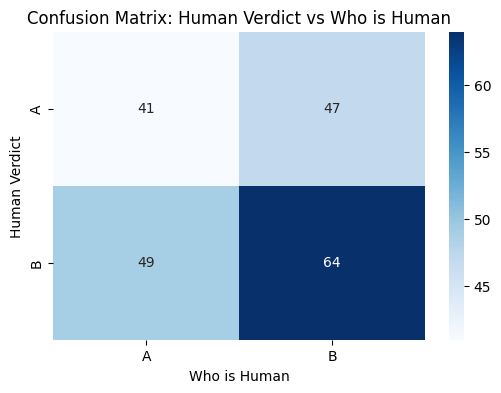

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["human_verdict"], output["who_is_human"],
                 rownames=["Human Verdict"], colnames=["Who is Human"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Human Verdict vs Who is Human")
plt.show()

In [29]:
sum(output["human_verdict"] == output["who_is_human"])/len(output)

0.5223880597014925

## Statement-Finder Accuracy

In [20]:
output = output[output["aijudge_verdict"].isin(["A", "B"])].copy()
len(output)

557

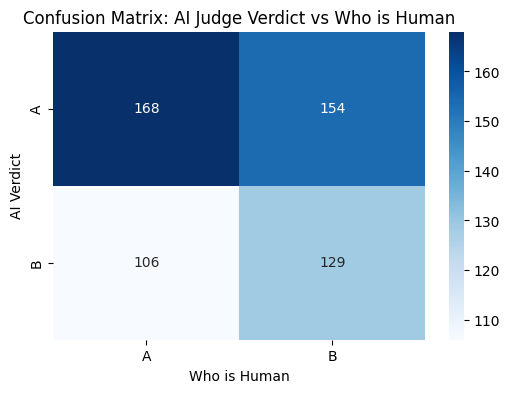

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["aijudge_verdict"], output["who_is_human"],
                 rownames=["AI Verdict"], colnames=["Who is Human"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: AI Judge Verdict vs Who is Human")
plt.show()

In [22]:
sum(output["aijudge_verdict"] == output["who_is_human"])/len(output)

0.533213644524237

In [23]:
from sklearn.metrics import f1_score

# Calculate F1 score for AI judge's verdict
# We need to convert the labels to numerical format for f1_score
output['who_is_human_numeric'] = output['who_is_human'].apply(lambda x: 1 if x == 'A' else 0)
output['aijudge_verdict_numeric'] = output['aijudge_verdict'].apply(lambda x: 1 if x == 'A' else 0)

f1 = f1_score(output['who_is_human_numeric'], output['aijudge_verdict_numeric'])

print(f"F1 Score for AI Judge's Verdict: {f1}")

F1 Score for AI Judge's Verdict: 0.5637583892617449


## Human-AI agreement

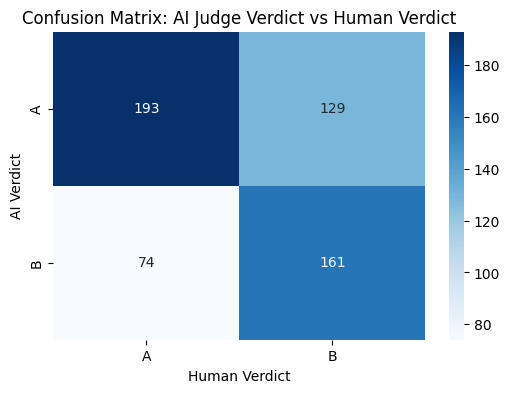

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = pd.crosstab(output["aijudge_verdict"], output["human_verdict"],
                 rownames=["AI Verdict"], colnames=["Human Verdict"])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: AI Judge Verdict vs Human Verdict")
plt.show()

In [87]:
sum(output["aijudge_verdict"] == output["human_verdict"])/len(output)

0.6355475763016158

In [26]:
file_paths

['run_9_gpt-4.1.csv',
 'run_8_gpt-4.1-mini.csv',
 'run_7_gpt-5.csv',
 'run_6_gpt-5-mini.csv',
 'run_4_gpt-oss.csv']

In [29]:
import pandas as pd

for filename in file_paths:
    output_path = f"FS_output/{filename}"
    
    output = pd.read_csv(output_path)
    output.rename(columns={"final-answer": "aijudge_verdict"}, inplace=True)
    output = output[output["aijudge_verdict"].isin(["A", "B"])].copy()
    print(filename, sum(output["aijudge_verdict"] == output["who_is_human"])/len(output))

run_9_gpt-4.1.csv 0.5368043087971275
run_8_gpt-4.1-mini.csv 0.4614003590664273
run_7_gpt-5.csv 0.6481149012567325
run_6_gpt-5-mini.csv 0.533213644524237
run_4_gpt-oss.csv 0.4236983842010772
